**Homework 9**

We begin with the imports you will need, together with the functions defined in previous assignments.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def TrainTestSplit(X,y,p,seed=1):
  '''Splits feature matrix X and target array y into train and test sets
  p is the fraction going to train'''
  np.random.seed(seed) #controls randomness
  size=len(y)
  train_size=int(p*size)
  train_mask=np.zeros(size,dtype=bool)
  train_indices=np.random.choice(size, train_size, replace=False)
  train_mask[train_indices]=True
  test_mask=~train_mask
  X_train=X[train_mask]
  X_test=X[test_mask]
  y_train=y[train_mask]
  y_test=y[test_mask]
  return X_train,X_test,y_train,y_test

def PolyFeatures(x,d):
  X=np.zeros((len(x),d+1))
  for i in range(d+1):
    X[:,i]=x**i
  return X

def AddOnes(X):
  return np.concatenate((X,np.ones((len(X),1))),axis=1)

class Scaler:
  def __init__(self,z):
    self.min=np.min(z,axis=0)
    self.max=np.max(z,axis=0)

  def scale(self,x):
    return (x-self.min)/(self.max-self.min)

  def unscale(self,x):
    return x*(self.max-self.min)+self.min

def train(X,y,max_iter,lr):
  '''MSE minimization by Gradient Descent'''
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  for i in range(max_iter):
    resid=X@coeff-y
    gradient=((X.T)@resid)/n #Lot's of lin alg here. Try to unpack it!
    coeff=coeff-lr*gradient #Gradient Descent step.
  return coeff

def SGD(X,y,epochs,batch_size,lr):
  '''Stochastic Gradient Descent'''
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  indices=np.arange(len(X))
  for i in range(epochs):
    np.random.seed(i) #Just so everyone gets the same answer!
    np.random.shuffle(indices)
    X_shuffle=X[indices]
    y_shuffle=y[indices]
    num_batches=n//batch_size
    for j in range(num_batches):
      X_batch=X_shuffle[j*batch_size:(j+1)*batch_size]
      y_batch=y_shuffle[j*batch_size:(j+1)*batch_size]
      resid=X_batch@coeff-y_batch
      gradient=((X_batch.T)@resid)/len(X_batch) #Unpack this lin alg!
      coeff=coeff-lr*gradient #Gradient Descent step.
    if n%batch_size!=0: #Check if there is a smaller leftover batch
      X_batch=X_shuffle[num_batches*batch_size:] #last batch
      y_batch=y_shuffle[num_batches*batch_size:] #last batch
      resid=X_batch@coeff-y_batch
      gradient=((X_batch.T)@resid)/len(X_batch)
      coeff=coeff-lr*gradient
  return coeff

def predict(X,coeff): #If X was scaled, then this will return scaled predictions
  return X@coeff

def MSE(pred,y):
  return np.sum((pred-y)**2)/len(y)

In this assignment you will modify the SGD function to allow for L1 (Lasso) and L2 (Ridge) regularization.

In [144]:
def SGD(X,y,epochs,batch_size,lr,alpha=0,beta=0):
  '''Stochastic Gradient Descent With L1 and L2 regularization'''
  #alpha=amount of L1 (Lasso) regularization
  #beta=amount of L2 (Ridge) regularization
  X=np.array(X) #Just in case X is a DataFrame
  y=np.array(y) #Just in case y is a Series
  n=len(X)
  coeff=np.ones(X.shape[1]) #Initialize all coeff to be 1 (something to play with?)
  indices=np.arange(len(X))
  for i in range(epochs):
    np.random.seed(i) #Just so everyone gets the same answer!
    np.random.shuffle(indices)
    X_shuffle=X[indices]
    y_shuffle=y[indices]
    num_batches=n//batch_size
    for j in range(num_batches):
      X_batch=X_shuffle[j*batch_size:(j+1)*batch_size]
      y_batch=y_shuffle[j*batch_size:(j+1)*batch_size]
      resid=X_batch@coeff-y_batch
      gradient=lr* ((X_batch.T)@resid)/len(X_batch)
      
      gradient += 2 * alpha * np.sign(coeff) + beta * coeff
      coeff=coeff-gradient #Gradient Descent step.
    if n%batch_size!=0: #Check if there is a smaller leftover batch
      X_batch=X_shuffle[num_batches*batch_size:] #last batch
      y_batch=y_shuffle[num_batches*batch_size:] #last batch
      resid=X_batch@coeff-y_batch
      gradient=lr*((X_batch.T)@resid)/len(X_batch)
      
      gradient += 2 * alpha * np.sign(coeff) + beta * coeff
      coeff=coeff-gradient
  return coeff

Let's make up some data to play with:

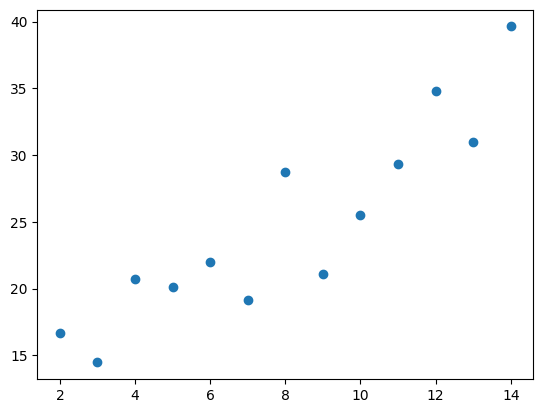

In [145]:
np.random.seed(4)
x=np.arange(2,15)
randoms=np.random.rand(13)
y=2*x+3+10*randoms
plt.scatter(x,y)

Now let's do a train/test split and fit an 8th degree polynomial model to the train set via SGD.

In [146]:
x_train,x_test,y_train,y_test=TrainTestSplit(x,y,0.75)
xscaler=Scaler(x_train)
yscaler=Scaler(y_train)
x_train_scaled=xscaler.scale(x_train)
X_train_scaled=PolyFeatures(x_train_scaled,8)
y_train_scaled=yscaler.scale(y_train)
coeff=SGD(X_train_scaled,y_train_scaled,100000,13,0.1)
pred_scaled=predict(X_train_scaled,coeff) #Generate predictions for the training set
pred=yscaler.unscale(pred_scaled)
MSE(pred,y_train) #MSE for the training set. Should be very low!!

6.23308217150672

To see the overfitting, let's run predictions on lots of values of x.

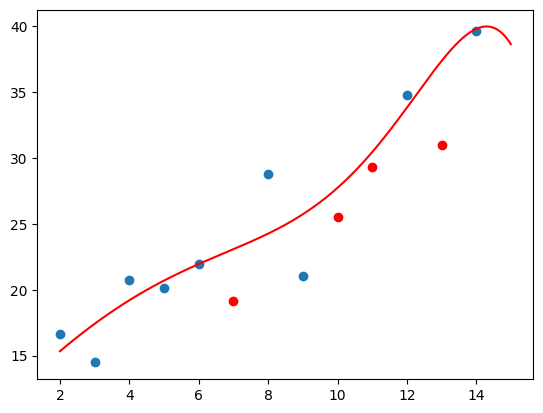

In [147]:
x_plot=np.arange(2,15,.01) # 1,300 values of x between 2 and 15
x_plot_scaled=xscaler.scale(x_plot)
X_plot_scaled=PolyFeatures(x_plot_scaled,8)
plot_pred_scaled=predict(X_plot_scaled,coeff) #Generate predictions for plotting
plot_pred=yscaler.unscale(plot_pred_scaled)
plt.scatter(x_train,y_train) #plot train set
plt.scatter(x_test,y_test,color='r') #plot test set
plt.plot(x_plot,plot_pred,'-r') #plot 1300 values and their predictions, and draw smooth curve


Now we check the MSE for the test set. As you might expect from the overfitting, this is much higher!

In [148]:
x_test_scaled=xscaler.scale(x_test)
X_test_scaled=PolyFeatures(x_test_scaled,8)
pred_scaled=predict(X_test_scaled,coeff) #generate predictions for the test set
pred=yscaler.unscale(pred_scaled)
MSE(pred,y_test) #MSE for the test set


15.662681781473346

Now let's do it again and add a little L2 regularization by setting beta=0.01 in the SGD function:

In [149]:
coeff=SGD(X_train_scaled,y_train_scaled,100000,13,0.1,beta=0.01)
pred_scaled=predict(X_test_scaled,coeff) #generate predictions for the test set
pred=yscaler.unscale(pred_scaled)
MSE_with_L2=MSE(pred,y_test) #MSE for the test set
MSE_with_L2

5.158809818036022

If your SGD function works, the MSE should be about 5. That's much better!!

---
*Assignment*

You will now explore the classic California housing dataset. Import it here:


In [150]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [151]:
from sklearn.datasets import fetch_california_housing
ca=fetch_california_housing(as_frame=True).frame
ca.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


In [152]:
ca.shape

(20640, 9)

Our goal is to find a model which predicts the MedHouseVal variable as accurately as possible. In the process of exploring this question, we will decide which of features are most important for prediction.

To start, you'll need to create a feature matrix X containing all of the columns besides MedHouseVal, and a target vector y containing the entries in MedHouseVal.

In [153]:
X=ca.drop(['MedHouseVal'], axis=1, inplace=False)
y=ca['MedHouseVal']

Now, do the following:
1. 80/20 Train-Test split
2. Scale the training feature matrix and training target array.
3. Add a column of ones.
4. Find the coefficients of a linear model using SGD with 1000 epochs, batch sizes of 5000, and a learning rate of 0.01. (For now, don't use any regularization.)

In [154]:
X_train,X_test,y_train,y_test = TrainTestSplit(X, y, 0.8)

In [182]:
X_train_scaled = X_train.copy()
X_train_scaled = np.transpose(X_train_scaled)

for column in X_train_scaled.columns:
    X_train_scaled[column] = Scaler(X_train_scaled[column]).scale(X_train_scaled[column])

X_train_scaled = np.transpose(X_train_scaled)

# X_train_scaled = (X_train-X_train.min())/(X_train.max()-X_train.min())


y_train_scaled = Scaler(y_train).scale(y_train)

In [183]:
X_train_scaled['b0'] = 1

In [184]:
#YOUR CODE HERE
epochs = 1000
batch_size = 5000
lr = 0.01

coeff=SGD(X_train_scaled, y_train_scaled, epochs, batch_size, lr)
coeff

array([ 0.16624471, -0.01433341,  0.13196753,  0.16846975,  0.1767181 ,
        0.1593252 , -0.07288238,  1.        ,  0.15656857])

Coefficients that are very close to zero indicate that the corresponding columns are an insignificant factor in making predictions with this model. How many coefficients are greater than -0.1 and less than 0.1?



In [185]:
mask = (coeff > -0.1) & (coeff < 0.1)

In [186]:
num_small_coeffs_no_regularization=np.count_nonzero(mask)
num_small_coeffs_no_regularization

2

Calculate the MSE for the test set.

In [174]:
X_test_scaled = X_test.copy()
# X_test_scaled = (X_test-X_test.min())/(X_test.max()-X_test.min())
# for column in X_test.columns:
#     X_test_scaled[column] = Scaler(X_test[column]).scale(X_test[column])
X_test_scaled['b0'] = 1

In [175]:

# pred_scaled = predict(X_test_scaled, coeff)
# pred = Scaler(pred_scaled).unscale(pred_scaled)

pred = predict(X_test_scaled, coeff)

In [176]:
MSE_no_reg=MSE(pred, y_test)
MSE_no_reg

2797582.080708738

To refine this model more, we can use a little L1 regularization to see which columns are *really* important (feature selection). Find another set of coefficients using SGD with the same number of epochs, batch size, and learning rate, but this time include a little L1 regularization by lettting alpha=10e-5 (i.e. 0.0001).

In [177]:
coeff_with_L1=SGD(X_train_scaled, y_train_scaled, epochs, batch_size, lr, alpha=0.0001)
coeff_with_L1

array([ 5.29002410e-01,  7.15594870e-02,  1.39416234e-01,  1.35964932e-01,
        1.62641727e-01,  1.93643980e-01,  1.91354908e-05, -2.36295245e-05,
        1.84940708e-01])

Now how many coefficients are now insignificant?

In [178]:
num_small_coeffs_with_regularization=np.count_nonzero(mask)
num_small_coeffs_with_regularization

0

Which columns of the original ca DataFrame do these correspond to? (Ignore the added column of ones, if that turns out to be insignificant.)

In [180]:
insig_indices = np.where(num_small_coeffs_with_regularization)[0]

/var/folders/pc/1h9xlpvd7rd5xtvc_7rkfznr0000gn/T/ipykernel_16103/3792352524.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  insig_indices = np.where(num_small_coeffs_with_regularization)[0]


In [181]:
insig_columns=ca.columns[insig_indices] #Insert indices of "insignificant" columns
insig_columns

Index([], dtype='object')

Now, do the following:
1. Drop the "insignificant" columns from the ca dataframe.
2. Do a new train-test split.
3. Scale the training feature matrix and training target (you'll need to define new Scaler objects).
4. Add a column of ones, *only if you found that column to be significant for prediction!*
5. Create a linear model with the same epochs, batch size, and learning rate as before (no regularization).
6. Determine the MSE on the test set.

You should find the MSE is about the same as before, indicating that the dropped columns really were unimportant for prediction.

In [ ]:
new_MSE=